<a href="https://colab.research.google.com/github/JMartinArocha/MasterBigData/blob/main/Representacion_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preprocesamiento**

In [84]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, normaltest
from pandas.plotting import scatter_matrix
import numpy as np


nombre_archivo = "BTC-2017min.csv"
df = pd.read_csv(nombre_archivo)

# Obtener el número de filas en el DataFrame
numero_filas = df.shape[0]

print(f"El DataFrame tiene {numero_filas} filas.")

# Hacemos una copia de nuestro dataFrame por seguridad
marketData = df.copy()

# Eliminar columnas que no sirven
marketData.drop('unix', axis=1, inplace=True)
marketData.drop('symbol', axis=1, inplace=True)

# Primero, convertir la columna 'dates' a datetime si aún no lo está
# Luego, establecer la columna 'date' como índice del DataFrame
marketData['date'] = pd.to_datetime(marketData['date'])
marketData.set_index('date', inplace=True)

marketData.sort_values(by='date', inplace=True)

marketData.head()
marketData.describe()

El DataFrame tiene 525599 filas.


,open,high,low,close,Volume BTC,Volume USD
count,525599.000000,525599.000000,525599.000000,525599.000000,525599.000000,5.255990e+05
mean,3948.408377,3952.208189,3943.751886,3948.339307,8.939796,4.143441e+04
std,3936.757966,3942.382649,3929.589942,3936.695963,20.779163,1.173633e+05
min,752.000000,752.810000,751.340000,752.040000,0.000000,0.000000e+00
25%,1197.450000,1197.980000,1197.040000,1197.460000,0.348564,7.167660e+02
50%,2567.440000,2569.370000,2565.350000,2567.170000,2.575998,7.249086e+03
75%,4535.565000,4539.405000,4531.030000,4535.000000,9.416233,3.294400e+04
max,19665.760000,19666.000000,19649.960000,19665.750000,1616.060001,5.145939e+06


In [85]:
# Calculo de nuevas variables numéricas

# Calculo de medias moviles simples (SMA)
marketData['SMA_24'] = marketData['close'].rolling(window=24).mean()
marketData['SMA_50'] = marketData['close'].rolling(window=50).mean()
marketData['SMA_200'] = marketData['close'].rolling(window=200).mean()

# Calcular la media móvil exponencial (EMA)
marketData['EMA_24'] = marketData['open'].ewm(span=24, adjust=False).mean()
marketData['EMA_50'] = marketData['open'].ewm(span=50, adjust=False).mean()
marketData['EMA_200'] = marketData['open'].ewm(span=200, adjust=False).mean()

# Calculo del indicador RSI

# Calcular los cambios en el precio
delta = marketData['close'].diff()

# Separar ganancias y pérdidas
gain = delta.clip(lower=0)
loss = -1 * delta.clip(upper=0)

# Calcular la media de las ganancias y pérdidas
window = 14  # Ajusta esto según tus necesidades
avg_gain = gain.rolling(window=window, min_periods=window).mean()
avg_loss = loss.rolling(window=window, min_periods=window).mean()

# Calcular RS y RSI
rs = avg_gain / avg_loss
marketData['RSI'] = 100 - (100 / (1 + rs))


# # Calculo de nuevas variables categoricas

marketData['Close_Above_EMA24'] = marketData['close'] > marketData['EMA_24']
marketData['Close_Above_EMA50'] = marketData['close'] > marketData['EMA_50']
marketData['Close_Above_EMA200'] = marketData['close'] > marketData['EMA_200']
marketData['EMA24_Above_EMA50'] = marketData['EMA_24'] > marketData['EMA_50']
marketData['EMA24_Above_EMA200'] = marketData['EMA_24'] > marketData['EMA_200']
marketData['EMA50_Above_EMA200'] = marketData['EMA_50'] > marketData['EMA_200']
marketData['isGreenCandle'] = marketData['open'] > marketData['close']
marketData['price_diff'] = marketData['close'] - marketData['open']
marketData['RSI_overbuy'] =  marketData['RSI'] > 70
marketData['RSI_oversell'] = marketData['RSI'] < 30

# Eliminar filas donde las columnas 'SMA_24', 'EMA_50' y 'EMA_"==' tienen valores nulos
marketData.dropna()
# Asignar el DataFrame limpio a una nueva variable
cleaned_marketData = marketData.dropna()
marketData = cleaned_marketData.copy()
# marketData.head()

# Comprueba si hay algún valor NaN en todo el DataFrame
# nan_exists = marketData.isnull().values.any()
# print("¿Existen valores NaN en el DataFrame?:", nan_exists)

In [86]:
# Normalización: Transforma los datos para que tengan un rango común, típicamente entre 0 y 1.
# Es útil cuando necesitas un rango limitado para tus variables.

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
marketData[['volume_BTC_normalized', 'volume_USD_normalized']] = scaler.fit_transform(marketData[['Volume BTC', 'Volume USD']])

# Estandarización: Transforma los datos para que tengan una media de 0 y una desviación estándar de 1.
# Esto es útil en algoritmos que asumen que los datos están centrados en cero y tienen varianza uniforme.
scaler = StandardScaler()
marketData[['volume_BTC_standardized', 'volume_USD_standardized']] = scaler.fit_transform(marketData[['Volume BTC', 'Volume USD']])

In [87]:
import pandas as pd

# Cargar el dataset
# Le damos la vuelta al dataset para empezar a generar operaciones basadas en la estrategia definida
# df = marketData.iloc[::-1]
df = marketData.copy()
# Inicializar variables
saldo_inicial = 10000
saldo = saldo_inicial
tamaño_operacion = 0.01  # 1% del saldo de la cuenta
take_profit = 0.01  # 1% de ganancia
stop_loss = 0.01  # 1% de pérdida
# operacion_abierta = False  # Flag para controlar si hay una operación abierta

# Lista para guardar los resultados de las operaciones
operaciones = []
operaciones_activas = []

ganancias = 0
perdidas = 0

# Iterar a través del DataFrame
for index, row in df.iterrows():
    precio_actual = row['close']
    # Comprobar las condiciones para abrir una operación
    # condicion_ema_rsi = precio_actual > row['EMA_24'] and \
    #                   precio_actual > row['EMA_50'] and \
    #                   precio_actual > row['EMA_200'] and \
    #                   row['EMA_24'] > row['EMA_50'] and \
    #                   row['EMA_50'] > row['EMA_200']

    condicion_ema_rsi = precio_actual < row['EMA_24'] and \
          precio_actual < row['EMA_50'] and \
          precio_actual < row['EMA_200'] and \
          row['EMA_24'] < row['EMA_50'] and \
          row['EMA_50'] < row['EMA_200'] and \
          row['RSI'] < 30

    if len(operaciones_activas) == 0 and condicion_ema_rsi == True:
        # Calcular el monto de la operación
        monto_operacion = saldo * tamaño_operacion

        if monto_operacion >= 1 and monto_operacion <= saldo:
          # Calcular precios de take profit y stop loss
          precio_entrada = precio_actual
          precio_take_profit = precio_entrada * (1 + take_profit)
          precio_stop_loss = precio_entrada * (1 - stop_loss)

          # Registrar la operación
          operacion = {
              'date': index,
              'precio_entrada': precio_entrada,
              'monto_operacion': monto_operacion,
              'BTC': monto_operacion/precio_entrada,
              'precio_take_profit': precio_take_profit,
              'precio_stop_loss': precio_stop_loss,
              'exitosa': None,
          }

          operaciones_activas.append(operacion)
          operaciones.append(operacion)

          saldo -= monto_operacion
          # print(f"Operacion Abierta de: {operacion}")

    # Verificar si la operación abierta alcanzó el take profit o el stop loss
    if len(operaciones_activas) >= 1 and \
        precio_actual >= operaciones_activas[-1]['precio_take_profit'] and \
        row['RSI'] > 70:

        operaciones[-1]['exitosa'] = True

        # Actualizar el saldo con el beneficio total
        beneficio = operaciones_activas[-1]['monto_operacion'] * (1 + take_profit)
        ganancias += beneficio
        # print(f"Saldo: {saldo} + {beneficio}")
        saldo += beneficio

        operaciones_activas.pop()
        # print(f"Operacion Ganada: Fecha: {index} Precio: {precio_actual} Beneficio: {beneficio} Saldo: {saldo}")

        # print(f"Operacion Exsitosa, el beneficio es: {beneficio}")
        # Formatear el número a dos decimales
        # saldoFormat = "{:.2f}".format(saldo)
        # print(f"El saldo actual es: {saldoFormat}")

    if len(operaciones_activas) >= 1 and \
        precio_actual <= operaciones_activas[-1]['precio_stop_loss']:
        operaciones[-1]['exitosa'] = False
        # Actualizar el saldo con la perdida total
        perdida = operaciones_activas[-1]['BTC'] * operaciones_activas[-1]['precio_stop_loss']
        perdidas += perdida
        saldo += perdida

        operaciones_activas.pop()
        # print(f"Operacion Perdida: Fecha: {index} Precio: {precio_actual} Perdida: {perdida} Saldo: {saldo}")
        # print(operaciones_activas)

# Análisis de las operaciones
# Esto es un ejemplo básico, puedes expandirlo según tus necesidades
total_operaciones = len(operaciones)
# ganancias = sum(o['monto_operacion'] for o in operaciones if o['precio_entrada'] * (1 + take_profit) <= o['precio_take_profit'])
# perdidas = sum(o['monto_operacion'] for o in operaciones if o['precio_entrada'] * (1 - stop_loss) >= o['precio_stop_loss'])

print(f"Total operaciones: {total_operaciones}")
operaciones_pendientes = len([operacion for operacion in operaciones if operacion['exitosa'] == None])
operaciones_exitosas = len([operacion for operacion in operaciones if operacion['exitosa'] == True])
operaciones_falladas = len([operacion for operacion in operaciones if operacion['exitosa'] == False])
print(f"Total pendientes: {operaciones_pendientes}")
print(f"Total Exitosas: {operaciones_exitosas}")
print(f"Total Fallidas: {operaciones_falladas}")

gananciasFormat = "{:.2f}".format(ganancias)
print(f"Ganancias totales: {gananciasFormat}")
perdidasFormat = "{:.2f}".format(perdidas)
print(f"Perdidas totales: {perdidasFormat}")
saldoFormat = "{:.2f}".format(saldo)
print(f"Saldo final: {saldoFormat}")


Total operaciones: 2443
Total pendientes: 1
Total Exitosas: 1272
Total Fallidas: 1170
Ganancias totales: 129862.73
Perdidas totales: 117153.73
Saldo final: 10001.37


In [ ]:
beneficio_total = 0
perdida_total = 0

for operacion in operaciones:
    if operacion['exitosa'] is not None:  # Asegurarse de que el estado de la operación esté definido
        if operacion['exitosa']:
            # Calcular el beneficio
            beneficio = operacion['precio_take_profit'] * operacion['BTC'] - operacion['precio_entrada'] * operacion['BTC']
            beneficio_total += beneficio
        else:
            # Calcular la pérdida
            perdida = operacion['precio_stop_loss'] * operacion['BTC'] - operacion['precio_entrada'] * operacion['BTC']
            perdida_total += perdida

print(f"Beneficio total: {beneficio_total}")
print(f"Pérdida total: {perdida_total}")


Beneficio total: 2141.7298816913567
Pérdida total: -87.99038322470922


In [ ]:
import csv
import pandas as pd

# Crear y abrir un archivo CSV para escribir los datos
with open('operaciones.csv', 'w', newline='', encoding='utf-8') as file:
    # Crear un objeto writer
    writer = csv.writer(file)

    # Escribir los encabezados (claves del diccionario)
    headers = operaciones[0].keys()
    writer.writerow(headers)

    # Escribir los valores de cada diccionario en el archivo CSV
    for operacion in operaciones:
        row = []
        for key in headers:
            # Convertir Timestamp a string si es necesario
            if isinstance(operacion[key], pd.Timestamp):
                row.append(operacion[key].strftime('%Y-%m-%d %H:%M:%S'))
            else:
                row.append(operacion[key])
        writer.writerow(row)


In [ ]:
import pandas as pd

# Cargar el conjunto de datos de operaciones si aún no está cargado
data_operaciones = pd.read_csv('operaciones.csv')

# Convertir la columna 'date' a datetime si aún no lo es
data_operaciones['date'] = pd.to_datetime(data_operaciones['date'])

# Asegurarse de que 'date' en data_btcusd también sea datetime
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])

# Fusionar los DataFrames basándose en la columna 'date'
data_combinado = pd.merge(df, data_operaciones, on='date')

# Guardar el DataFrame combinado en un archivo CSV
ruta_guardado = 'data_combinado.csv'  # Puedes cambiar esto por la ruta y nombre de archivo que prefieras
data_combinado.to_csv(ruta_guardado, index=False)



**Analisis**

In [ ]:
marketData = data_combinado.copy()

In [ ]:
sns.set_theme(style="ticks")

sns.pairplot(marketData, hue="close")

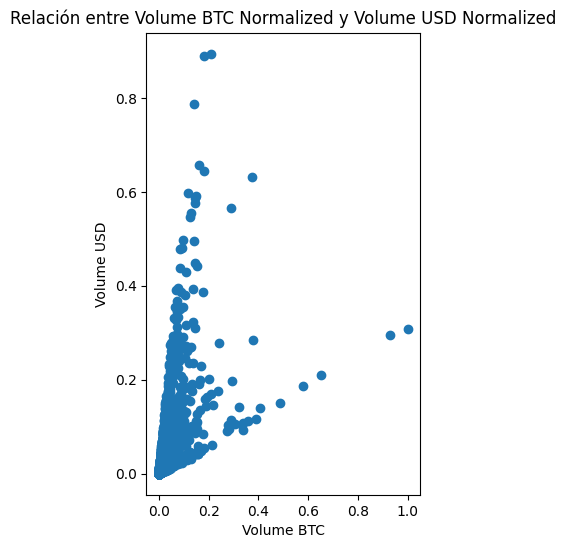

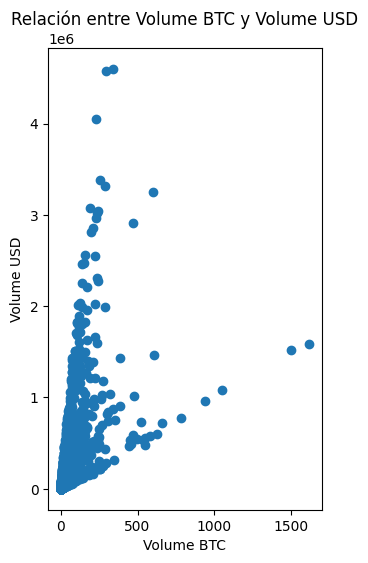

In [ ]:
# Gráficos de Dispersión: Visualiza las relaciones entre las dos variables con un gráfico de dispersión.
# Configura el tamaño de la figura que contendrá todas las subgráficas

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1) # 1 fila, 3 columnas, posición 1
plt.scatter(marketData['volume_BTC_normalized'], marketData['volume_USD_normalized'])
plt.xlabel('Volume BTC')
plt.ylabel('Volume USD')
plt.title('Relación entre Volume BTC Normalized y Volume USD Normalized')
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 2) # 1 fila, 3 columnas, posición 2
plt.scatter(marketData['Volume BTC'], marketData['Volume USD'])
plt.xlabel('Volume BTC')
plt.ylabel('Volume USD')
plt.title('Relación entre Volume BTC y Volume USD')
plt.show()


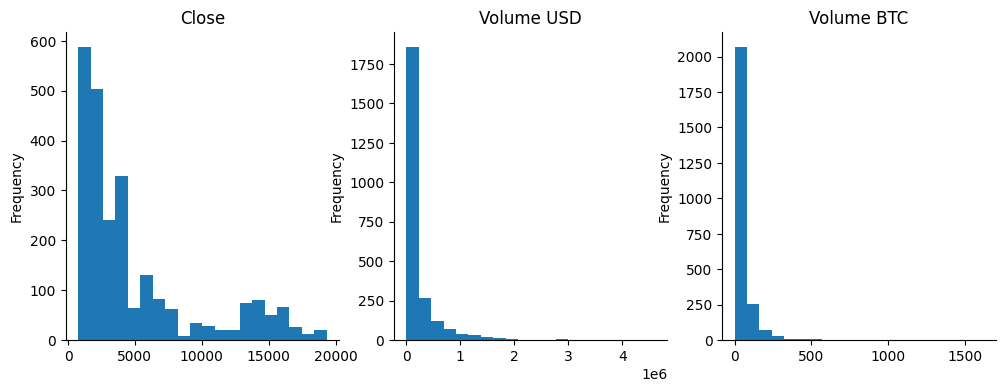

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 4))

# Gráfica para Close_Above_EMA24
plt.subplot(1, 3, 1) # 1 fila, 3 columnas, posición 1
marketData['close'].plot(kind='hist', bins=20, title='Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.subplot(1, 3, 2) # 1 fila, 3 columnas, posición 2
marketData['Volume USD'].plot(kind='hist', bins=20, title='Volume USD')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.subplot(1, 3, 3) # 1 fila, 3 columnas, posición 3
marketData['Volume BTC'].plot(kind='hist', bins=20, title='Volume BTC')
plt.gca().spines[['top', 'right',]].set_visible(False)

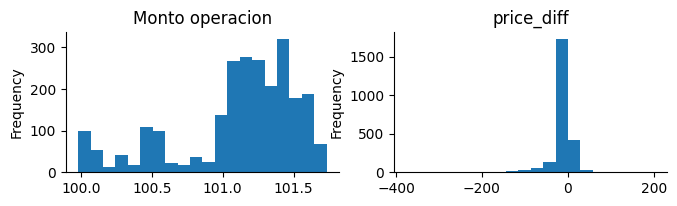

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(2, 3, 1) # 1 fila, 3 columnas, posición 3
marketData['monto_operacion'].plot(kind='hist', bins=20, title='Monto operacion')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.subplot(2, 3, 2) # 1 fila, 3 columnas, posición 3
marketData['price_diff'].plot(kind='hist', bins=20, title='price_diff')
plt.gca().spines[['top', 'right',]].set_visible(False)

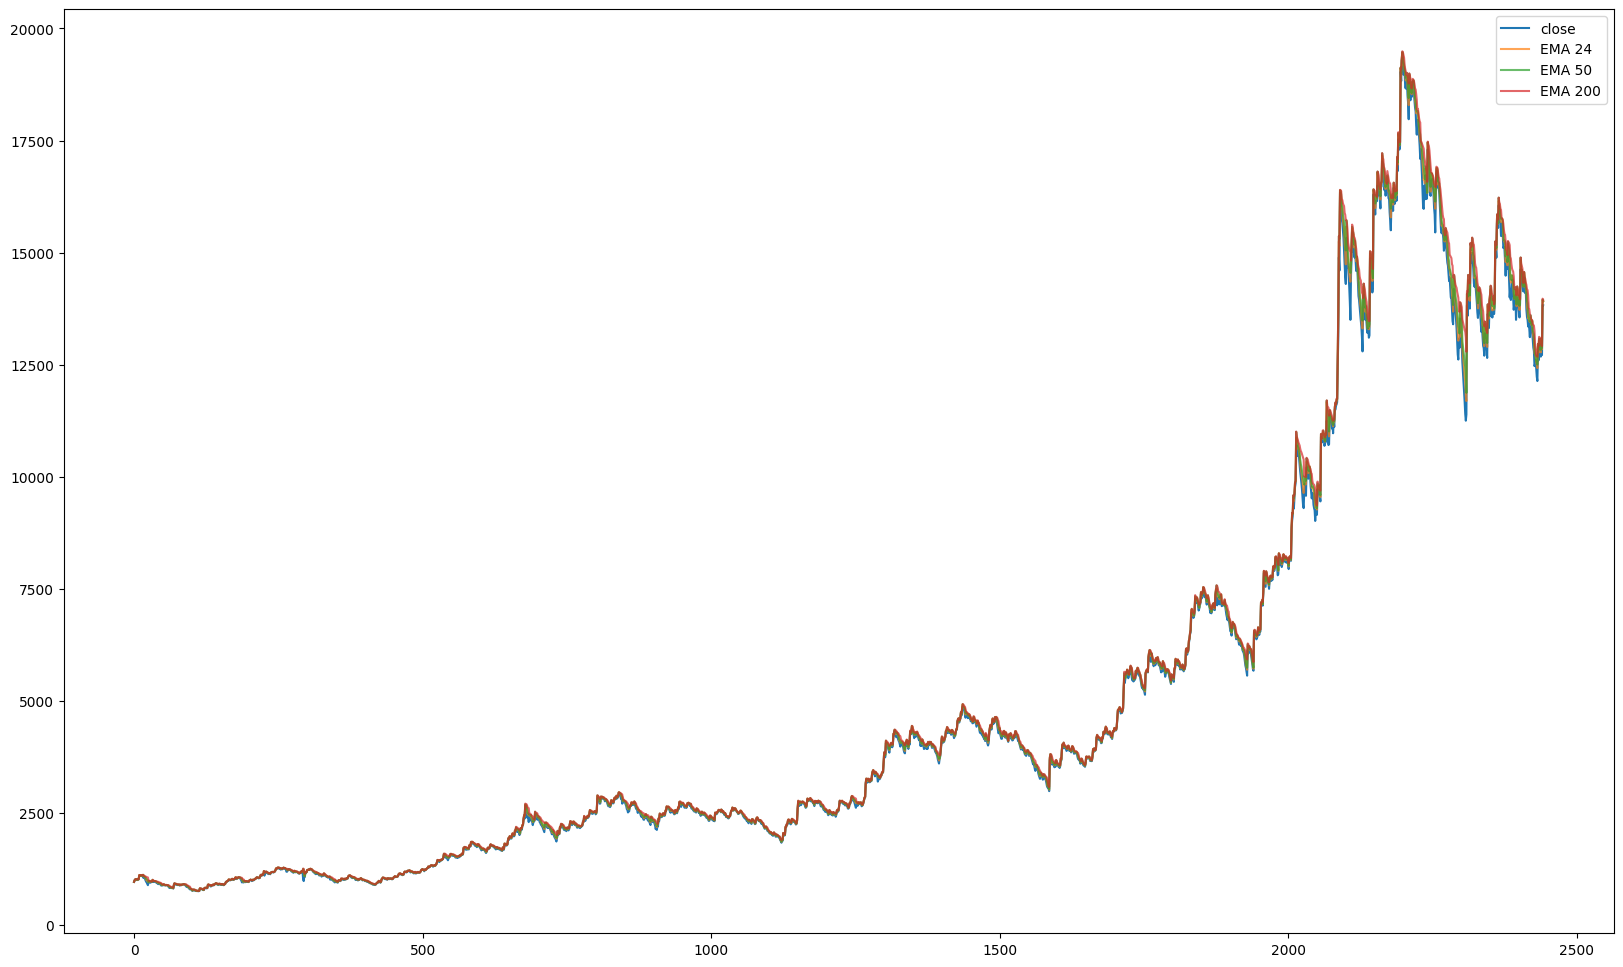

In [ ]:
# Visualizacion por fecha en especifico

# Define tus fechas de inicio y fin para el rango
fecha_inicio = '2017-01-01 00:42:00'
fecha_fin = '2017-01-15 04:57:00'

# Selecciona el rango de fechas en tu DataFrame
# marketData_rango = marketData[fecha_inicio:fecha_fin]
marketData_rango = marketData

# Plot
plt.figure(figsize=(20, 12))
plt.plot(marketData_rango['close'], label='close')
plt.plot(marketData_rango['EMA_24'], label='EMA 24', alpha=0.7)
plt.plot(marketData_rango['EMA_50'], label='EMA 50', alpha=0.7)
plt.plot(marketData_rango['EMA_200'], label='EMA 200', alpha=0.7)

plt.legend()
plt.show()



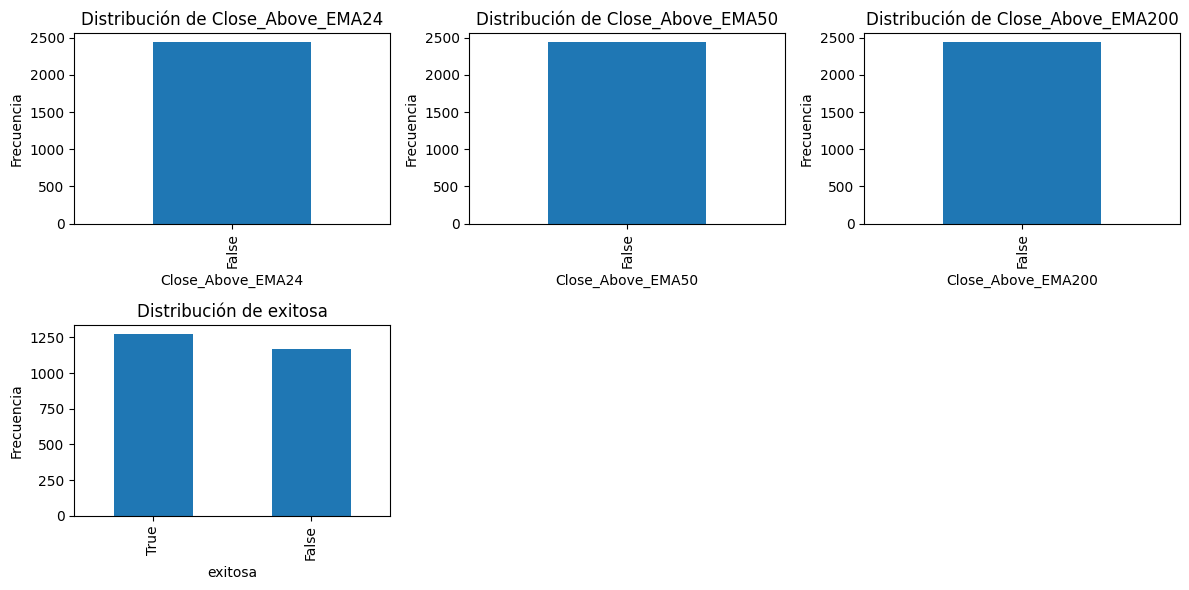

In [ ]:
import matplotlib.pyplot as plt

# Configura el tamaño de la figura que contendrá todas las subgráficas
plt.figure(figsize=(12, 6))

# Gráfica para Close_Above_EMA24
plt.subplot(2, 3, 1) # 1 fila, 2 columnas, posición 1
marketData['Close_Above_EMA24'].value_counts().plot(kind='bar')
plt.title('Distribución de Close_Above_EMA24')
plt.xlabel('Close_Above_EMA24')
plt.ylabel('Frecuencia')

# Gráfica para Close_Above_EMA50
plt.subplot(2, 3, 2) # 1 fila, 2 columnas, posición 2
marketData['Close_Above_EMA50'].value_counts().plot(kind='bar')
plt.title('Distribución de Close_Above_EMA50')
plt.xlabel('Close_Above_EMA50')
plt.ylabel('Frecuencia')

# Gráfica para Close_Above_EMA200
plt.subplot(2, 3, 3) # 1 fila, 2 columnas, posición 2
marketData['Close_Above_EMA200'].value_counts().plot(kind='bar')
plt.title('Distribución de Close_Above_EMA200')
plt.xlabel('Close_Above_EMA200')
plt.ylabel('Frecuencia')

# Gráfica para Close_Above_EMA200
plt.subplot(2, 3, 4) # 1 fila, 2 columnas, posición 2
marketData['exitosa'].value_counts().plot(kind='bar')
plt.title('Distribución de exitosa')
plt.xlabel('exitosa')
plt.ylabel('Frecuencia')

# Muestra todas las subgráficas
plt.tight_layout() # Ajusta automáticamente los parámetros de la subtrama
plt.show()


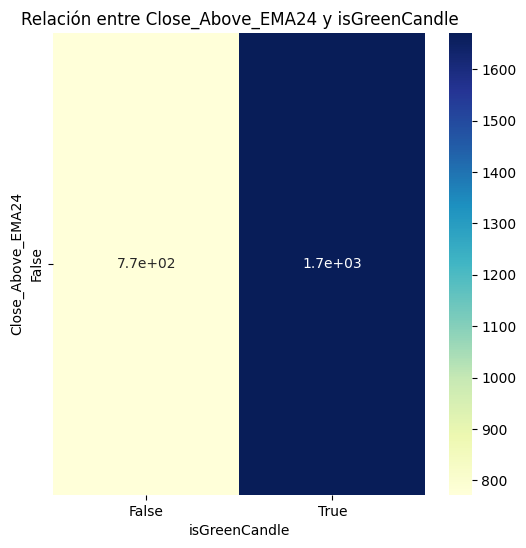

In [ ]:
import seaborn as sns
import pandas as pd

# Ejemplo de relación entre 'Close_Above_EMA24' y 'isGreenCandle'
contingency_table = pd.crosstab(marketData['Close_Above_EMA24'], marketData['isGreenCandle'])

# Visualizando con un heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.title('Relación entre Close_Above_EMA24 y isGreenCandle')
plt.show()


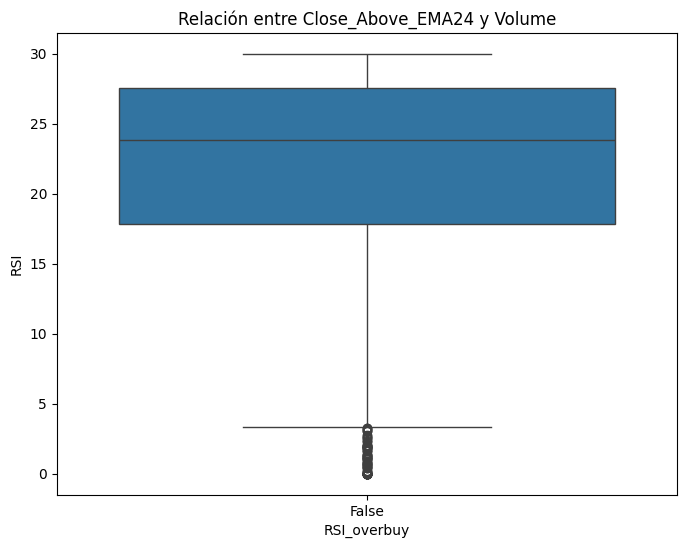

In [ ]:
# Relación entre Variables Categóricas y Cuantitativas

# Ejemplo para la relación entre 'Close_Above_EMA24' y 'Volume'
# plt.figure(figsize=(8, 6))
# sns.boxplot(x='isGreenCandle', y='price_diff', data=marketData)
# plt.title('Relación entre Close_Above_EMA24 y Volume')
# plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='RSI_overbuy', y='RSI', data=marketData)
plt.title('Relación entre Close_Above_EMA24 y Volume')
plt.show()


<ipython-input-55-fc798071d7fc>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = marketData.corr().abs()  # abs() si solo te interesan las magnitudes


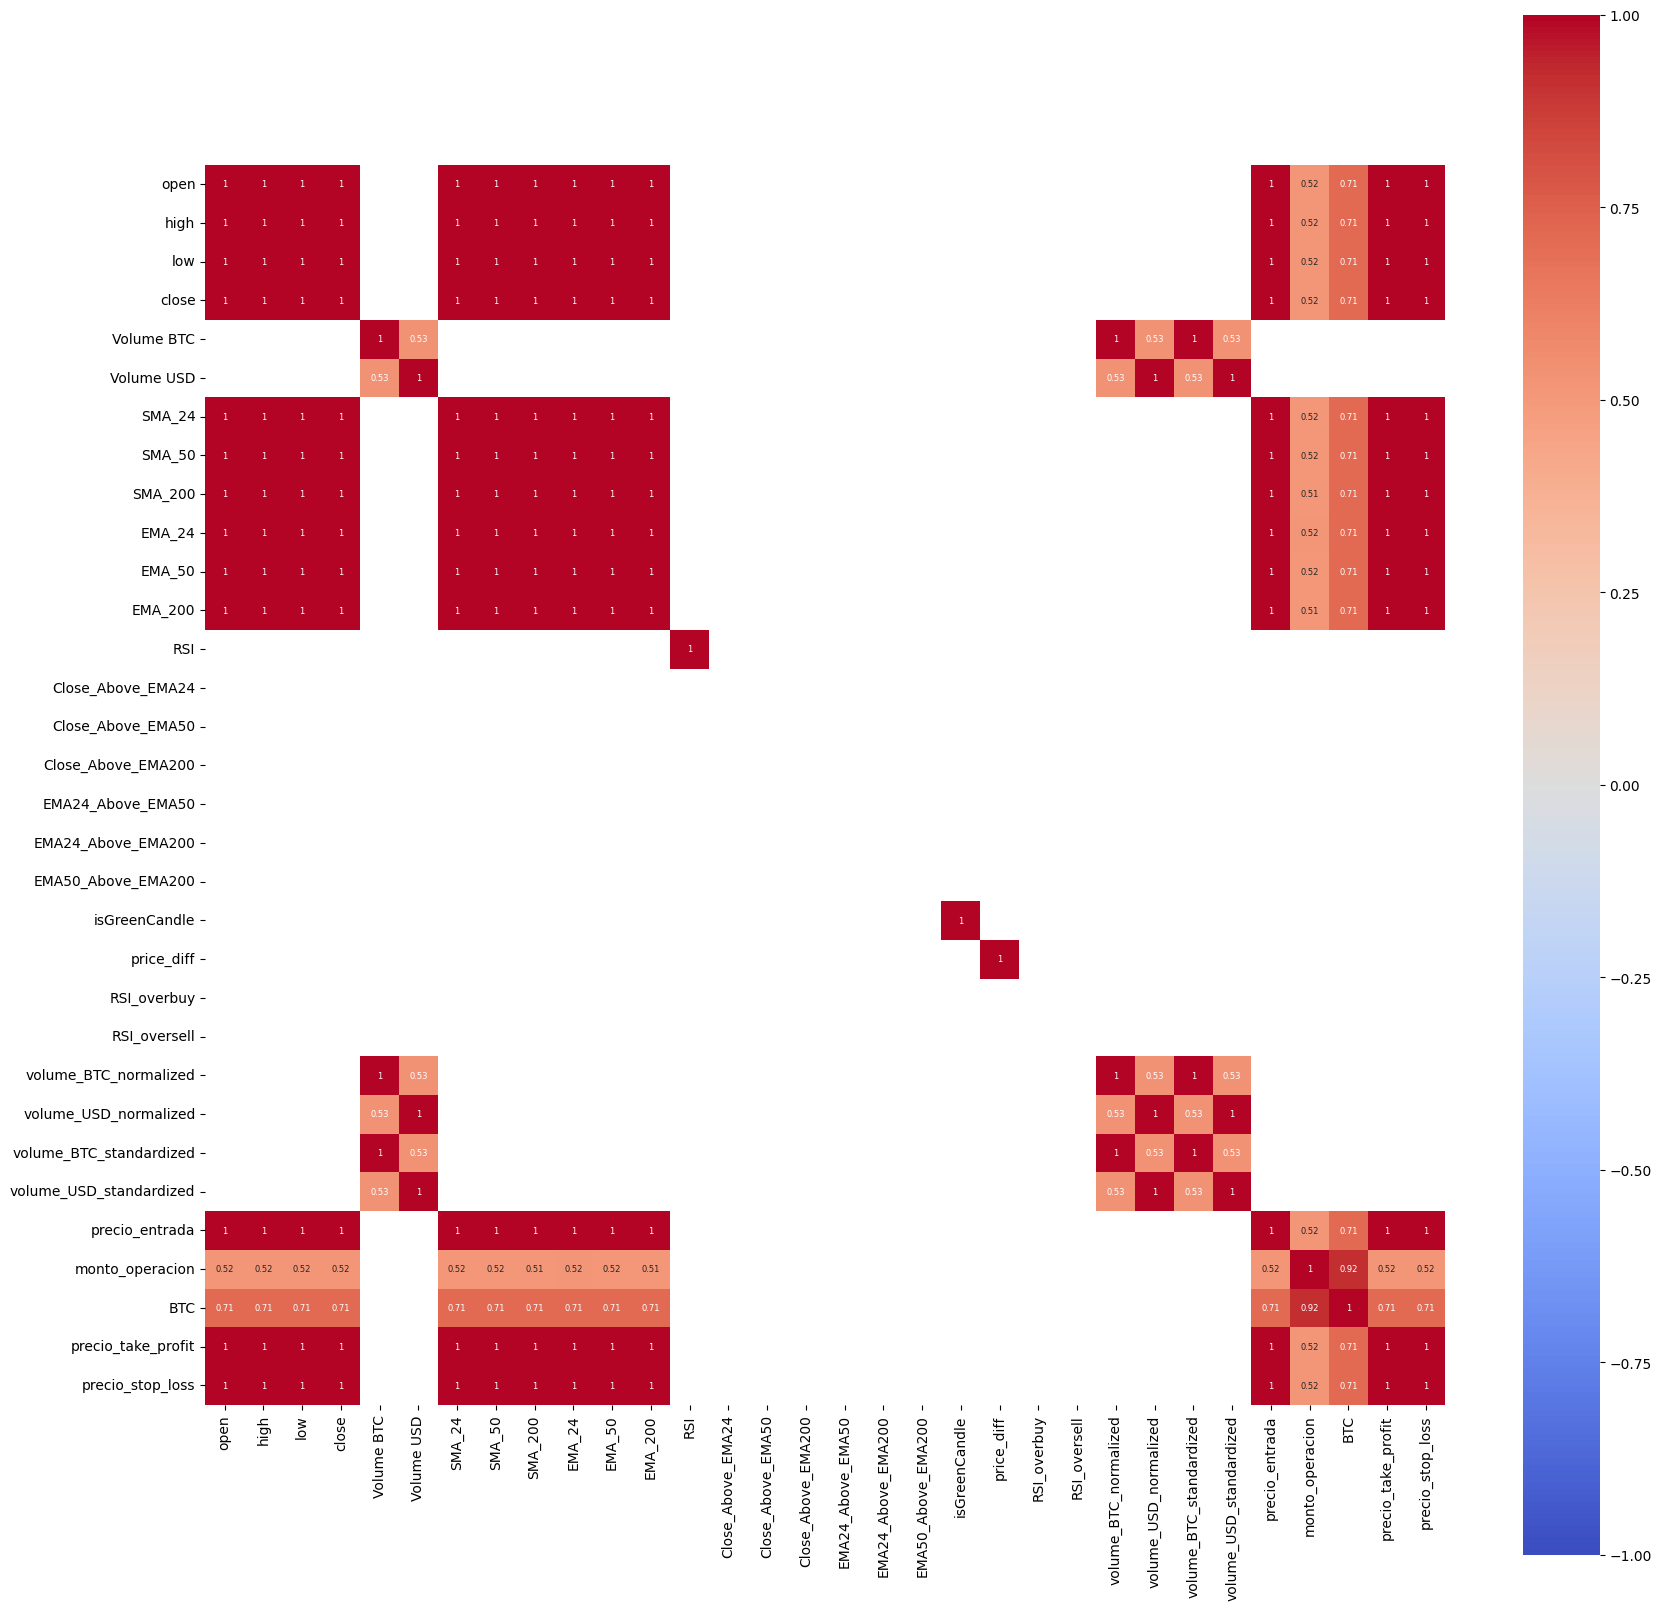

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aumentar el tamaño del gráfico
plt.figure(figsize=(20, 20))  # Ajusta según tu pantalla

# Calcular la matriz de correlación y aplicar un umbral
corr_matrix = marketData.corr().abs()  # abs() si solo te interesan las magnitudes
high_corr = corr_matrix[corr_matrix > 0.5]

# Usar heatmap con la matriz de correlación ajustada
sns.heatmap(high_corr, square=True, annot=True, cmap='coolwarm',
            vmin=-1, vmax=1, annot_kws={"size": 6})  # Ajusta el tamaño de la anotación según sea necesario

# Mostrar el gráfico
plt.show()


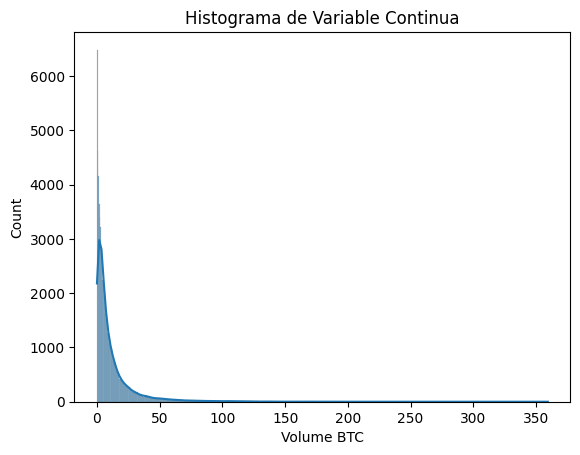

In [ ]:
# Histogramas: Utilizados para representar la distribución de una variable numérica continua. Muestra cuántas veces caen los datos en distintos rangos de valores.
sns.histplot(marketData['Volume BTC'], kde=True)
plt.title('Histograma de Variable Continua')
plt.show()



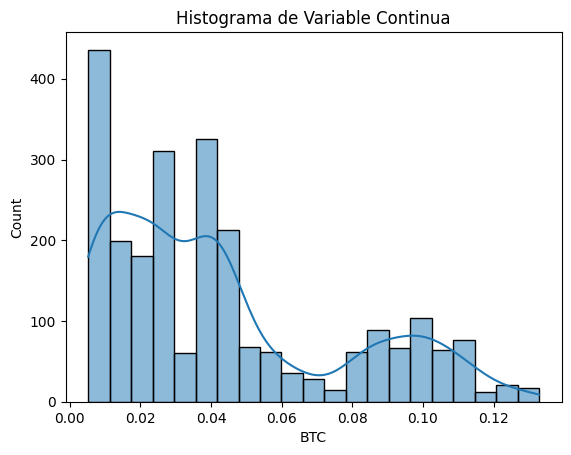

In [ ]:
# Histogramas: Utilizados para representar la distribución de una variable numérica continua. Muestra cuántas veces caen los datos en distintos rangos de valores.
sns.histplot(marketData['BTC'], kde=True)
plt.title('Histograma de Variable Continua')
plt.show()

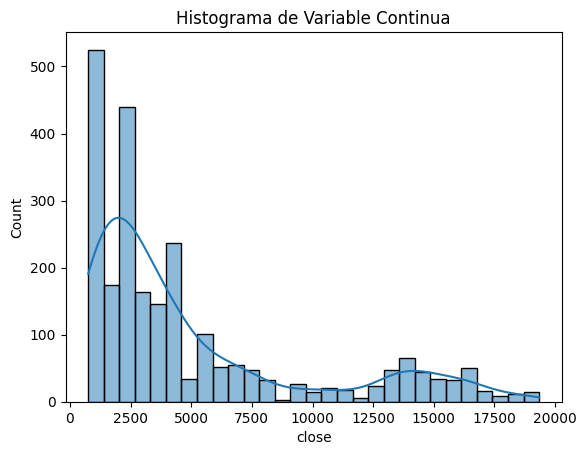

In [ ]:
sns.histplot(marketData['close'], kde=True)
plt.title('Histograma de Variable Continua')
plt.show()

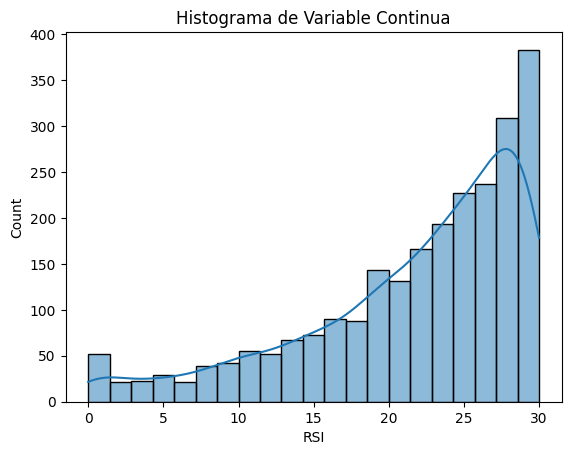

In [ ]:
sns.histplot(marketData['RSI'], kde=True)
plt.title('Histograma de Variable Continua')
plt.show()

In [ ]:
# sns.histplot(marketData['price_diff'], kde=True)
# plt.title('Histograma de Variable Continua')
# plt.show()

# sns.boxplot(x=marketData['price_diff'])
# plt.show()

from scipy import stats

# # Calcular el Z-Score para identificar outliers en una columna
# z_scores = np.abs(stats.zscore(marketData['Volume USD']))
# # Definir un umbral de Z-Score para identificar outliers (por ejemplo, 3 desviaciones estándar)
# threshold = 3

# # Encontrar índices de outliers
# outlier_indices = np.where(z_scores > threshold)


# # Obtener los valores de los outliers
# outliers = marketData['Volume USD'].iloc[outlier_indices]

# print("Outliers:")
# print(outliers)

# Calcular el rango intercuartil (IQR)
Q1 = marketData['Volume USD'].quantile(0.25)
Q3 = marketData['Volume USD'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Encontrar índices de outliers
outlier_indices = np.where((marketData['Volume USD'] < lower_limit) | (marketData['Volume USD'] > upper_limit))

# Obtener los valores de los outliers
outliers = marketData['Volume USD'].iloc[outlier_indices]

print("Outliers:")
print(outliers)

Outliers:
date
2017-12-31 18:57:00    503506.614225
2017-12-31 17:37:00    756175.290154
2017-12-31 17:24:00    883983.525336
2017-12-31 17:14:00    567865.742410
2017-12-31 17:04:00    444086.820368
                           ...      
2017-11-12 11:43:00    624829.494518
2017-11-12 11:16:00    413570.527571
2017-11-12 11:15:00    811243.031136
2017-11-12 11:14:00    557482.576728
2017-11-12 10:43:00    467485.859299
Name: Volume USD, Length: 6522, dtype: float64


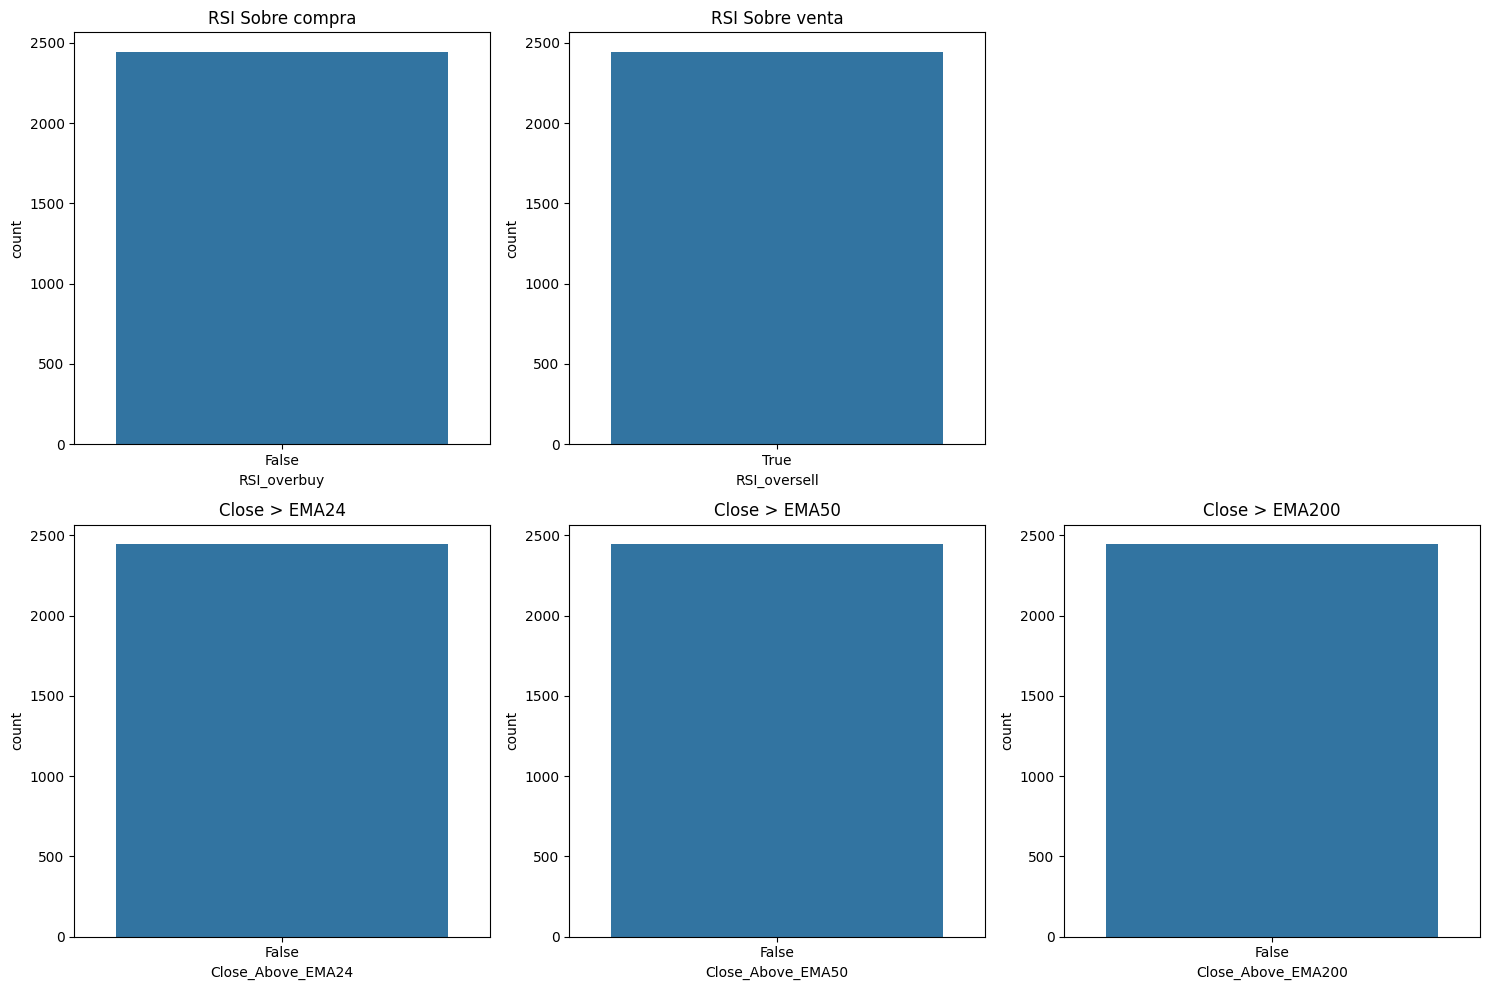

In [ ]:
# Gráficos de Barras: Utilizados para comparar diferentes categorías o variables discretas.

# Crear una figura y una cuadrícula de subplots de 2 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Subplot 1: RSI Sobre compra
sns.countplot(data=marketData, x='RSI_overbuy', ax=axes[0, 0])
axes[0, 0].set_title('RSI Sobre compra')

# Subplot 2: RSI Sobre venta
sns.countplot(data=marketData, x='RSI_oversell', ax=axes[0, 1])
axes[0, 1].set_title('RSI Sobre venta')
axes[0, 2].axis('off')

# Subplot 3: Close > EMA24
sns.countplot(data=marketData, x='Close_Above_EMA24', ax=axes[1, 0])
axes[1, 0].set_title('Close > EMA24')

# Subplot 4: Close > EMA50
sns.countplot(data=marketData, x='Close_Above_EMA50', ax=axes[1, 1])
axes[1, 1].set_title('Close > EMA50')

# Subplot 5: Close > EMA200
sns.countplot(data=marketData, x='Close_Above_EMA200', ax=axes[1, 2])
axes[1, 2].set_title('Close > EMA200')

# Asegúrate de que el último subplot esté en blanco, ya que tienes 2 filas y 3 columnas
# axes[1, 2].axis('off')

# Ajusta automáticamente los espacios entre subplots para que no se superpongan
plt.tight_layout()

# Muestra los subplots
plt.show()


In [ ]:
# Scatterplots (Diagramas de Dispersión)

# Relaciones entre Variables: Para visualizar la relación o correlación entre dos variables numéricas.

sns.scatterplot(x='variable_x', y='variable_y', data=marketData)
plt.title('Relación entre Variable X y Variable Y')
plt.show()


In [ ]:
# Box and Whiskers Plot (Diagramas de Caja y Bigotes)

# Distribución y Outliers: Muestra la distribución de una variable numérica y es útil para detectar outliers.

sns.boxplot(x='variable_categorica', y='variable_numerica', data=marketData)
plt.title('Distribución de Variable Numérica por Categoría')
plt.show

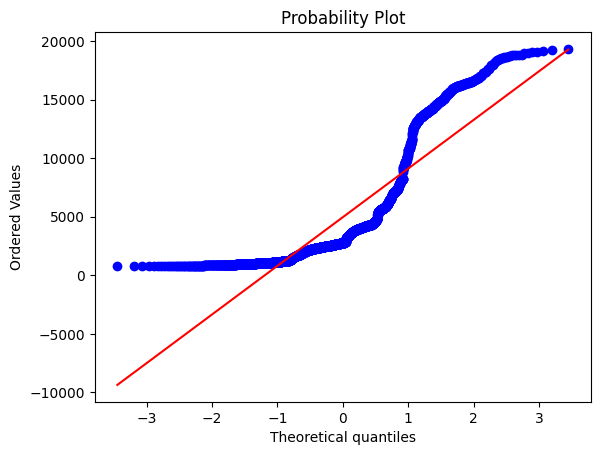

In [ ]:
# Gráfico Q-Q
stats.probplot(marketData['close'], dist="norm", plot=plt)
plt.show()

In [ ]:
# Prueba de Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(marketData['close'])

# Prueba de D'Agostino's K^2
dagostino_stat, dagostino_p = normaltest(marketData['close'])

print(f"Shapiro-Wilk: p={shapiro_p}, D'Agostino's K^2: p={dagostino_p}")

Shapiro-Wilk: p=0.0, D'Agostino's K^2: p=5.636525343058753e-112


**Modelo**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Cargar tus datos
# Asegúrate de reemplazar 'ruta_al_archivo.csv' con la ruta a tu archivo CSV
data = pd.read_csv('data_combinado.csv')
data = data.dropna()

# Suponiendo que 'columna_exitosa' es tu columna de etiquetas
data['exitosa'] = data['exitosa'].astype(int)
data['Close_Above_EMA24'] = data['Close_Above_EMA24'].astype(int)
data['Close_Above_EMA50'] = data['Close_Above_EMA50'].astype(int)
data['Close_Above_EMA200'] = data['Close_Above_EMA200'].astype(int)
data['EMA24_Above_EMA50'] = data['EMA24_Above_EMA50'].astype(int)
data['EMA24_Above_EMA200'] = data['EMA24_Above_EMA200'].astype(int)
data['EMA24_Above_EMA50'] = data['EMA24_Above_EMA200'].astype(int)
data['isGreenCandle'] = data['isGreenCandle'].astype(int)
data['RSI_overbuy'] = data['RSI_overbuy'].astype(int)
data['RSI_oversell'] = data['RSI_oversell'].astype(int)



# Convertir la columna de fecha/hora en datetime si aún no lo está
data['date'] = pd.to_datetime(data['date'])

# Extraer características como el día de la semana, hora, etc.
data['dia_semana'] = data['date'].dt.dayofweek
data['hora'] = data['date'].dt.hour

# Ahora elimina la columna original de fecha/hora
X = data.drop(['exitosa', 'date'], axis=1)

# Seleccionar tus características (X) y la etiqueta (y)
# Asegúrate de cambiar estas columnas según tu conjunto de datos
y = data['exitosa']  # La columna que indica si la operación fue exitosa

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de árbol de decisión
model = GaussianNB()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del Modelo: {accuracy}')
print(classification_report(y_test, y_pred))

# Puedes guardar el modelo entrenado usando joblib si planeas usarlo más tarde
# from joblib import dump
# dump(model, 'modelo_operaciones_exitosas.joblib')


Precisión del Modelo: 0.5784447476125512
              precision    recall  f1-score   support

           0       0.61      0.27      0.37       342
           1       0.57      0.85      0.68       391

    accuracy                           0.58       733
   macro avg       0.59      0.56      0.53       733
weighted avg       0.59      0.58      0.54       733



In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

clasificadores = [GaussianNB(),BernoulliNB()]
for clasificador in clasificadores:
    # separamos datos de entrada y salida
    # X_iris = iris.drop('species', axis=1)
    # y_iris = iris['species']
    # # separamos train y test
    # Xtrain, Xtest, ytrain, ytest = train_test_split(X_iris, y_iris, test_size=0.33, random_state=1)
    data = pd.read_csv('data_combinado.csv')
    data = data.dropna()

    # Suponiendo que 'columna_exitosa' es tu columna de etiquetas
    data['exitosa'] = data['exitosa'].astype(int)
    data['Close_Above_EMA24'] = data['Close_Above_EMA24'].astype(int)
    data['Close_Above_EMA50'] = data['Close_Above_EMA50'].astype(int)
    data['Close_Above_EMA200'] = data['Close_Above_EMA200'].astype(int)
    data['EMA24_Above_EMA50'] = data['EMA24_Above_EMA50'].astype(int)
    data['EMA24_Above_EMA200'] = data['EMA24_Above_EMA200'].astype(int)
    data['EMA24_Above_EMA50'] = data['EMA24_Above_EMA200'].astype(int)
    data['isGreenCandle'] = data['isGreenCandle'].astype(int)
    data['RSI_overbuy'] = data['RSI_overbuy'].astype(int)
    data['RSI_oversell'] = data['RSI_oversell'].astype(int)



    # Convertir la columna de fecha/hora en datetime si aún no lo está
    data['date'] = pd.to_datetime(data['date'])

    # Extraer características como el día de la semana, hora, etc.
    data['dia_semana'] = data['date'].dt.dayofweek
    data['hora'] = data['date'].dt.hour

    # Ahora elimina la columna original de fecha/hora
    X = data.drop(['exitosa', 'date'], axis=1)

    # Seleccionar tus características (X) y la etiqueta (y)
    # Asegúrate de cambiar estas columnas según tu conjunto de datos
    y = data['exitosa']  # La columna que indica si la operación fue exitosa

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


    nombre_clasificador = clasificador.__class__.__name__
    # 2. instanciamos el modelo
    model = clasificador
    # 3. Entrenamiento con los datos
    model.fit(X_train, y_train)
    # 4. Predicción con nuevos datos
    y_model = model.predict(X_test)

    # 5 evaluación
    # Compara si los resultados obtenidos por el modelo (y_model) coinciden con los datos y_test esperados
    score = accuracy_score(y_test, y_model) # Precisión del modelo
    print(f"Modelo: {nombre_clasificador} Score: {score}")

Modelo: GaussianNB Score: 0.5784447476125512
Modelo: BernoulliNB Score: 0.5184174624829468


In [ ]:
from sklearn.model_selection import KFold
# Añadimos cross validation
crossValidation = KFold(n_splits = 5, shuffle = True) # shuffle = False si hay dimensión temporal

total_scores = []
for clasificador in clasificadores:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  model = clasificador
  fold_accuracy = []
  for train_fold, test_fold in crossValidation.split(X_train):
      # División train test aleatoria
      f_train_x = X_train.iloc[train_fold] # Extrae la información (iloc), atendiendo a los indices obtenidos por CrossValidation
      f_train_y = y_train.iloc[train_fold]
      # entrenamiento
      model.fit(f_train_x, f_train_y)
      # Realizamos la predicción (Final evaluation) y guardamos la precisión para calcular la media posteriormente
      y_pred = model.predict(X_train.iloc[test_fold])
      # evaluación del modelo
      acc = accuracy_score(y_train.iloc[test_fold], y_pred)
      fold_accuracy.append(acc)

  total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
print('Con Cross Validation')
for i in range(len(clasificadores)):
    nombre_clasificador = f"{clasificadores[i].__class__.__name__}"
    print(f"Modelo: {nombre_clasificador} Score: {total_scores[i]}")

Con Cross Validation
Modelo: GaussianNB Score: 0.52781464903706
Modelo: BernoulliNB Score: 0.5207696661007357
